96.72919672919673% of samples were classified correctly !
{'A': {'precision': 0.9888888888888889, 'recall': 0.9888888888888889, 'f1-score': 0.9888888888888889, 'support': 180.0}, 'B': {'precision': 0.989010989010989, 'recall': 1.0, 'f1-score': 0.994475138121547, 'support': 180.0}, 'C': {'precision': 0.9880952380952381, 'recall': 0.9764705882352941, 'f1-score': 0.9822485207100592, 'support': 170.0}, 'D': {'precision': 0.9651162790697675, 'recall': 0.9822485207100592, 'f1-score': 0.9736070381231672, 'support': 169.0}, 'E': {'precision': 0.96, 'recall': 0.9385474860335196, 'f1-score': 0.9491525423728814, 'support': 179.0}, 'F': {'precision': 0.9774011299435028, 'recall': 0.9719101123595506, 'f1-score': 0.9746478873239437, 'support': 178.0}, 'G': {'precision': 0.9726027397260274, 'recall': 0.9726027397260274, 'f1-score': 0.9726027397260274, 'support': 146.0}, 'H': {'precision': 0.9612403100775194, 'recall': 0.9763779527559056, 'f1-score': 0.96875, 'support': 127.0}, 'I': {'precision': 0.97

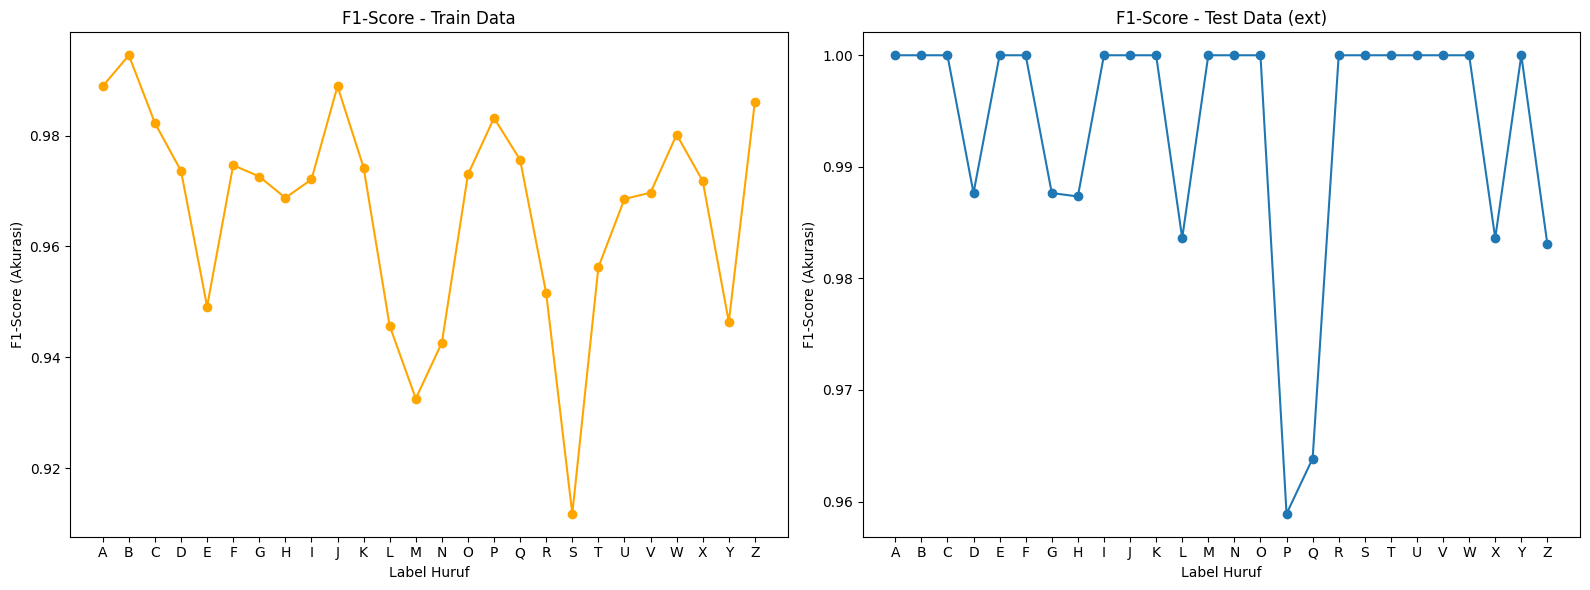

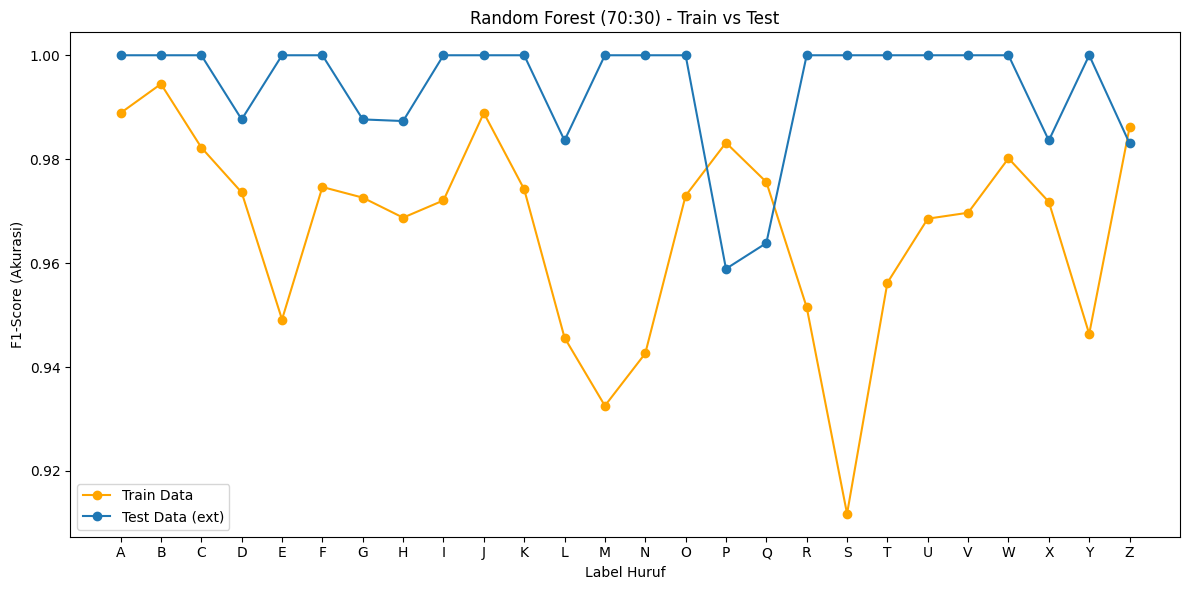

In [42]:
# --- Random Forest (70 : 30)

import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

# Muat data
data_dict = pickle.load(open('../train_data.pickle', 'rb'))

# Periksa bentuk dari setiap elemen dalam data_dict['data']
# Buat daftar untuk menyimpan data yang valid
valid_data = []

for sample in data_dict['data']:
    if len(sample) == 42:  # Pastikan panjang fitur adalah 42
        valid_data.append(sample)

# Konversi ke array NumPy
data = np.array(valid_data)  # Harus berukuran (n_samples, 42)
labels = np.array(data_dict['labels'][:len(valid_data)])  # Sesuaikan dengan jumlah data valid

# Membuat labels_dict untuk pemetaan huruf
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}

# Split data menjadi training dan testing
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, shuffle=True, stratify=labels)

# Inisialisasi dan latih model
model = RandomForestClassifier()

# Data sudah memiliki bentuk yang sesuai
model.fit(x_train, y_train)

# Prediksi dan hitung skor akurasi
y_predict = model.predict(x_test)
score = accuracy_score(y_predict, y_test)
print('{}% of samples were classified correctly !'.format(score * 100))

# Cek apakah file model.p sudah ada
model_filename = 'model.p'
if os.path.exists(model_filename):
    # Jika ada, rename menjadi model1.p, model2.p, dst.
    i = 1
    new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    while os.path.exists(new_filename):
        i += 1
        new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    os.rename(model_filename, new_filename)

# Tentukan folder untuk menyimpan model
model_folder = '../model-tuning/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Tentukan nama file model dengan increment
i = 1
model_filename = os.path.join(model_folder, 'rf_model_73.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_73_{i}.p')
    i += 1

# Simpan model ke file
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model}, f)

# Generate classification report
report = classification_report(y_test, y_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)
print(report)

# Ekstraksi akurasi (f1-score) untuk setiap kelas
class_names = list(sorted(labels_dict.values()))
f1_scores = [report[class_name]['f1-score'] for class_name in class_names]

# Membuat DataFrame untuk seaborn
df_report = pd.DataFrame({'Label': class_names, 'F1-Score': f1_scores})

# === LOAD DAN EVALUASI TEST DATA EKSTERNAL ===
# Muat test data dari file test_data.pickle
test_data_dict = pickle.load(open('../test_data.pickle', 'rb'))

# Filter dan validasi data test (harus panjang fitur = 42)
valid_test_data = [sample for sample in test_data_dict['data'] if len(sample) == 42]

# Pastikan valid_test_data tidak kosong
if not valid_test_data:
    raise ValueError("No valid test data found. Ensure that the test data contains samples with the correct feature length.")

test_data = np.array(valid_test_data)
test_labels = np.array(test_data_dict['labels'][:len(valid_test_data)])

# Prediksi test data eksternal
test_predict = model.predict(test_data)

# Classification report untuk test data
external_report = classification_report(test_labels, test_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)

# Ekstraksi F1-score dari test data
f1_scores_external = [external_report[class_name]['f1-score'] for class_name in class_names]

# Buat 1 baris 2 kolom subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# # === Barplot di axes[0] ===
# sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])
# axes[0].set_xlabel('Label Huruf')
# axes[0].set_ylabel('F1-Score (Akurasi)')
# axes[0].set_title('Barplot F1-Score per Label')

# # Tambahkan nilai F1 pada batang barplot
# for p in axes[0].patches:
#     height = p.get_height()
#     axes[0].text(p.get_x() + p.get_width() / 2., height / 2.,
#                  '{:1.2f}%'.format(height * 100),
#                  ha='center', va='center', rotation='vertical',
#                  bbox=dict(facecolor='white', edgecolor='none', pad=2))

# === Line plot di axes[0] ===
axes[0].plot(df_report['Label'], df_report['F1-Score'], linestyle='-', color='orange', marker='o')
axes[0].set_xlabel('Label Huruf')
axes[0].set_ylabel('F1-Score (Akurasi)')
axes[0].set_title('F1-Score - Train Data')

# === Line plot di axes[1] ===
axes[1].plot(df_report['Label'], f1_scores_external, linestyle='-', color='C0', marker='o')
axes[1].set_xlabel('Label Huruf')
axes[1].set_ylabel('F1-Score (Akurasi)')
axes[1].set_title('F1-Score - Test Data (ext)')

plt.tight_layout()
plt.show()

# === LINE PLOT PERBANDINGAN ===
plt.figure(figsize=(12, 6))
plt.plot(df_report['Label'], df_report['F1-Score'], marker='o', linestyle='-', color='orange', label='Train Data')
plt.plot(df_report['Label'], f1_scores_external, marker='o', linestyle='-', color='C0', label='Test Data (ext)')

# Label dan title
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score (Akurasi)')
plt.title('Random Forest (70:30) - Train vs Test')
# plt.grid(True)
plt.legend()

# Tambahkan nilai di atas titik untuk kedua garis
# for x, y1, y2 in zip(df_report['Label'], df_report['F1-Score'], f1_scores_external):
#     plt.text(x, y1 + 0.02, f'{y1*100:.0f}%', ha='center', va='bottom', color='orange')
#     plt.text(x, y2 + 0.02, f'{y2*100:.0f}%', ha='center', va='bottom', color='C0')

plt.tight_layout()
plt.show()


96.89754689754689% of samples were classified correctly !
{'A': {'precision': 0.994475138121547, 'recall': 1.0, 'f1-score': 0.997229916897507, 'support': 180.0}, 'B': {'precision': 0.994475138121547, 'recall': 1.0, 'f1-score': 0.997229916897507, 'support': 180.0}, 'C': {'precision': 0.9941176470588236, 'recall': 0.9941176470588236, 'f1-score': 0.9941176470588236, 'support': 170.0}, 'D': {'precision': 0.9881656804733728, 'recall': 0.9881656804733728, 'f1-score': 0.9881656804733728, 'support': 169.0}, 'E': {'precision': 0.9712643678160919, 'recall': 0.9441340782122905, 'f1-score': 0.9575070821529745, 'support': 179.0}, 'F': {'precision': 0.9941860465116279, 'recall': 0.9606741573033708, 'f1-score': 0.9771428571428571, 'support': 178.0}, 'G': {'precision': 0.972972972972973, 'recall': 0.9863013698630136, 'f1-score': 0.9795918367346939, 'support': 146.0}, 'H': {'precision': 0.9920634920634921, 'recall': 0.984251968503937, 'f1-score': 0.9881422924901185, 'support': 127.0}, 'I': {'precision'

C:\Users\ACER\AppData\Local\Temp\ipykernel_23960\1473059814.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])


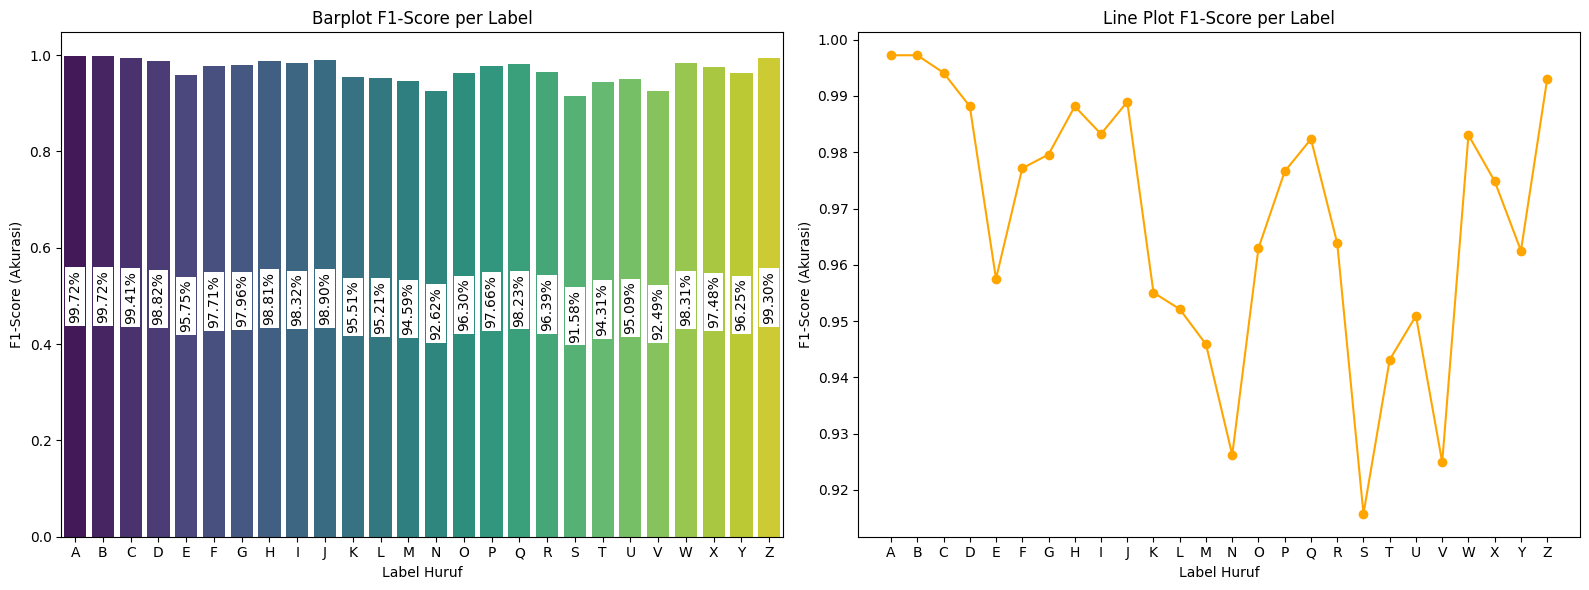

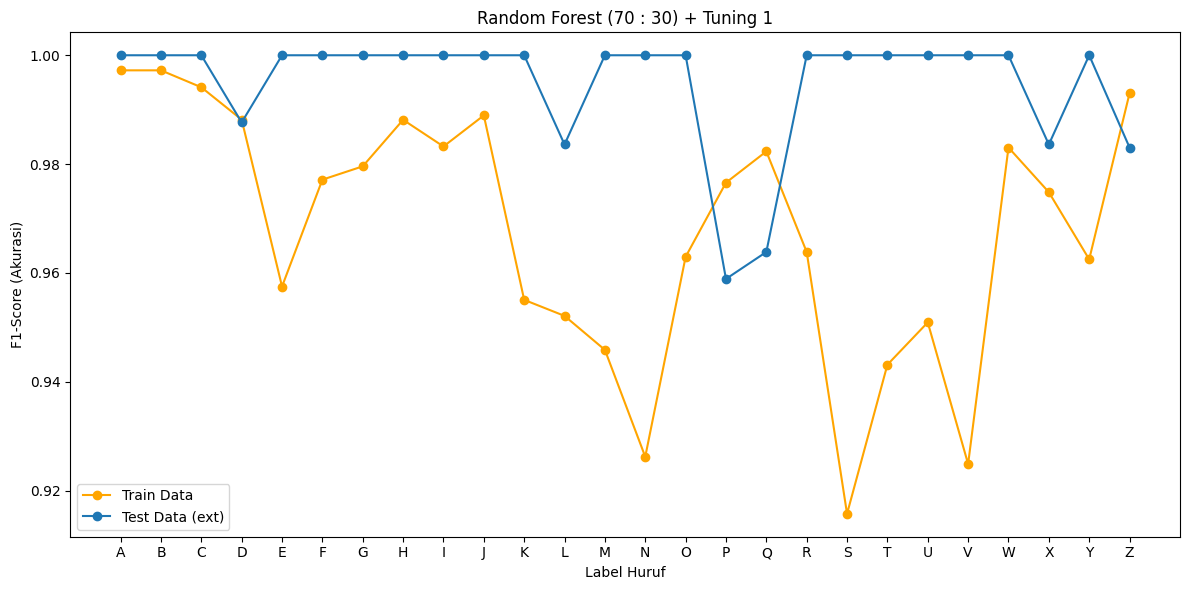

In [33]:
# --- Random Forest (70 : 30) + Tuning 1

import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

# Muat data
data_dict = pickle.load(open('../train_data.pickle', 'rb'))

# Periksa bentuk dari setiap elemen dalam data_dict['data']
# Buat daftar untuk menyimpan data yang valid
valid_data = []

for sample in data_dict['data']:
    if len(sample) == 42:  # Pastikan panjang fitur adalah 42
        valid_data.append(sample)

# Konversi ke array NumPy
data = np.array(valid_data)  # Harus berukuran (n_samples, 42)
labels = np.array(data_dict['labels'][:len(valid_data)])  # Sesuaikan dengan jumlah data valid

# Membuat labels_dict untuk pemetaan huruf
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}

# Split data menjadi training dan testing
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, shuffle=True, stratify=labels)

# Inisialisasi dan latih model
model = RandomForestClassifier(
    n_estimators=200,         # Jumlah pohon, bisa dicoba 100-500
    max_depth=20,             # Maksimal kedalaman tiap pohon
    min_samples_split=5,      # Minimum sampel untuk split internal node
    min_samples_leaf=2,       # Minimum sampel untuk leaf node
    max_features='sqrt',      # Fitur yang dipilih saat split
    bootstrap=True,           # Gunakan bootstrap sampling
    random_state=42,          # Untuk reproduksibilitas
    n_jobs=-1                 # Gunakan semua core CPU
)

# Data sudah memiliki bentuk yang sesuai
model.fit(x_train, y_train)

# Prediksi dan hitung skor akurasi
y_predict = model.predict(x_test)
score = accuracy_score(y_predict, y_test)
print('{}% of samples were classified correctly !'.format(score * 100))

# Cek apakah file model.p sudah ada
model_filename = 'model.p'
if os.path.exists(model_filename):
    # Jika ada, rename menjadi model1.p, model2.p, dst.
    i = 1
    new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    while os.path.exists(new_filename):
        i += 1
        new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    os.rename(model_filename, new_filename)

# Tentukan folder untuk menyimpan model
model_folder = '../model-tuning/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Tentukan nama file model dengan increment
i = 1
model_filename = os.path.join(model_folder, 'rf_model_73_tn1.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_73_tn1_{i}.p')
    i += 1

# Simpan model ke file
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model}, f)

# Generate classification report
report = classification_report(y_test, y_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)
print(report)

# Ekstraksi akurasi (f1-score) untuk setiap kelas
class_names = list(sorted(labels_dict.values()))
f1_scores = [report[class_name]['f1-score'] for class_name in class_names]

# Membuat DataFrame untuk seaborn
df_report = pd.DataFrame({'Label': class_names, 'F1-Score': f1_scores})

# Buat 1 baris 2 kolom subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === Barplot di axes[0] ===
sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])
axes[0].set_xlabel('Label Huruf')
axes[0].set_ylabel('F1-Score (Akurasi)')
axes[0].set_title('Barplot F1-Score per Label')

# Tambahkan nilai F1 pada batang barplot
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height / 2.,
                 '{:1.2f}%'.format(height * 100),
                 ha='center', va='center', rotation='vertical',
                 bbox=dict(facecolor='white', edgecolor='none', pad=2))

# === Line plot di axes[1] ===
axes[1].plot(df_report['Label'], df_report['F1-Score'], linestyle='-', color='orange', marker='o')
axes[1].set_xlabel('Label Huruf')
axes[1].set_ylabel('F1-Score (Akurasi)')
axes[1].set_title('Line Plot F1-Score per Label')

plt.tight_layout()
plt.show()

# === LOAD DAN EVALUASI TEST DATA EKSTERNAL ===
# Muat test data dari file test_data.pickle
test_data_dict = pickle.load(open('../test_data.pickle', 'rb'))

# Filter dan validasi data test (harus panjang fitur = 42)
valid_test_data = [sample for sample in test_data_dict['data'] if len(sample) == 42]

# Pastikan valid_test_data tidak kosong
if not valid_test_data:
    raise ValueError("No valid test data found. Ensure that the test data contains samples with the correct feature length.")

test_data = np.array(valid_test_data)
test_labels = np.array(test_data_dict['labels'][:len(valid_test_data)])

# Prediksi test data eksternal
test_predict = model.predict(test_data)

# Classification report untuk test data
external_report = classification_report(test_labels, test_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)

# Ekstraksi F1-score dari test data
f1_scores_external = [external_report[class_name]['f1-score'] for class_name in class_names]

# === LINE PLOT PERBANDINGAN ===
plt.figure(figsize=(12, 6))
plt.plot(df_report['Label'], df_report['F1-Score'], marker='o', linestyle='-', color='orange', label='Train Data')
plt.plot(df_report['Label'], f1_scores_external, marker='o', linestyle='-', color='C0', label='Test Data (ext)')

# Label dan title
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score (Akurasi)')
plt.title('Random Forest (70 : 30) + Tuning 1')
# plt.grid(True)
plt.legend()

# Tambahkan nilai di atas titik untuk kedua garis
# for x, y1, y2 in zip(df_report['Label'], df_report['F1-Score'], f1_scores_external):
#     plt.text(x, y1 + 0.02, f'{y1*100:.0f}%', ha='center', va='bottom', color='orange')
#     plt.text(x, y2 + 0.02, f'{y2*100:.0f}%', ha='center', va='bottom', color='C0')

plt.tight_layout()
plt.show()


96.75324675324676% of samples were classified correctly !
{'A': {'precision': 0.9836065573770492, 'recall': 1.0, 'f1-score': 0.9917355371900827, 'support': 180.0}, 'B': {'precision': 0.9944444444444445, 'recall': 0.9944444444444445, 'f1-score': 0.9944444444444445, 'support': 180.0}, 'C': {'precision': 0.9940119760479041, 'recall': 0.9764705882352941, 'f1-score': 0.9851632047477745, 'support': 170.0}, 'D': {'precision': 0.9647058823529412, 'recall': 0.9704142011834319, 'f1-score': 0.967551622418879, 'support': 169.0}, 'E': {'precision': 0.9548022598870056, 'recall': 0.9441340782122905, 'f1-score': 0.949438202247191, 'support': 179.0}, 'F': {'precision': 0.9831460674157303, 'recall': 0.9831460674157303, 'f1-score': 0.9831460674157303, 'support': 178.0}, 'G': {'precision': 0.9791666666666666, 'recall': 0.9657534246575342, 'f1-score': 0.9724137931034482, 'support': 146.0}, 'H': {'precision': 0.9541984732824428, 'recall': 0.984251968503937, 'f1-score': 0.9689922480620154, 'support': 127.0},

C:\Users\ACER\AppData\Local\Temp\ipykernel_23960\1012925646.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])


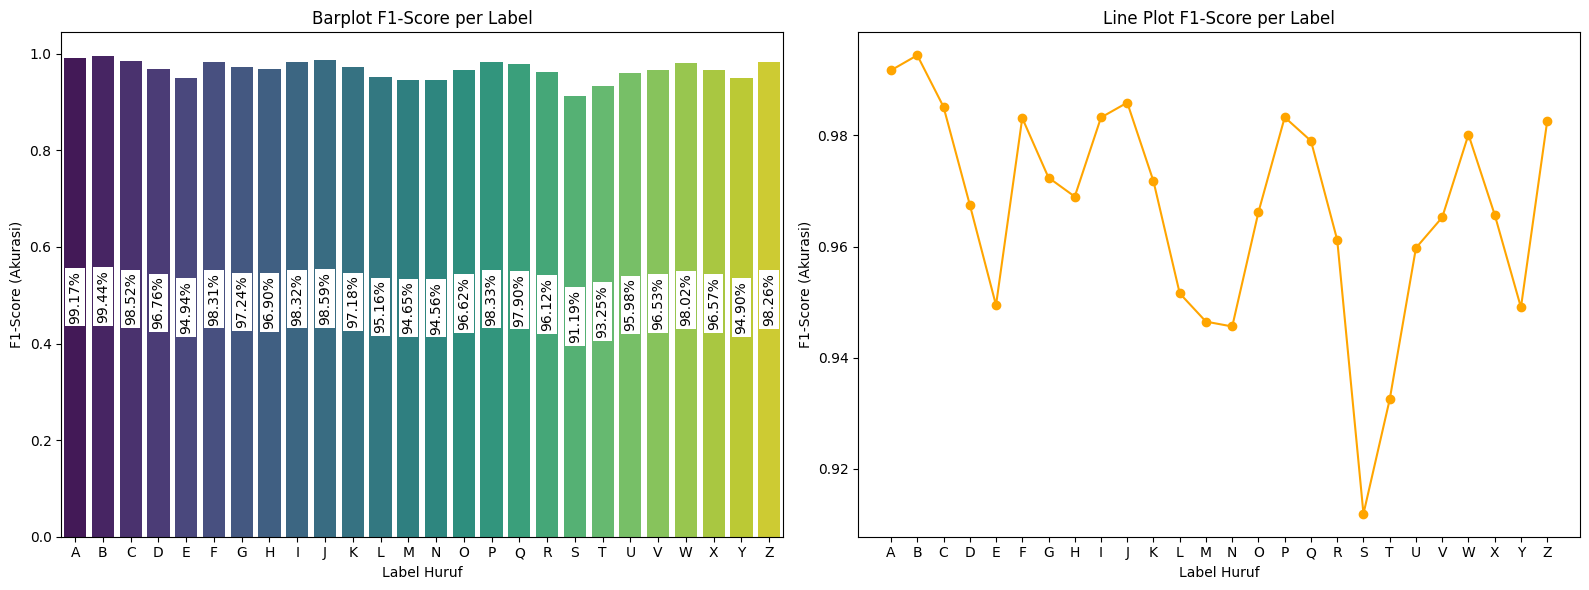

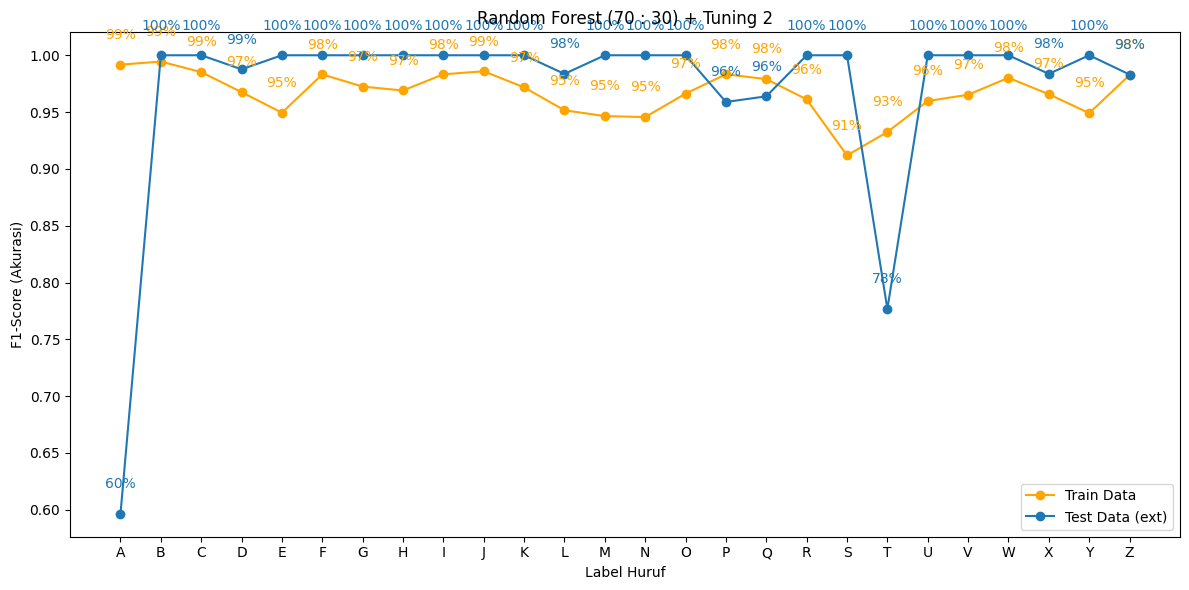

In [34]:
# --- Random Forest (70 : 30) + Tuning 2

import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

# Muat data
data_dict = pickle.load(open('../train_data.pickle', 'rb'))

# Periksa bentuk dari setiap elemen dalam data_dict['data']
# Buat daftar untuk menyimpan data yang valid
valid_data = []

for sample in data_dict['data']:
    if len(sample) == 42:  # Pastikan panjang fitur adalah 42
        valid_data.append(sample)

# Konversi ke array NumPy
data = np.array(valid_data)  # Harus berukuran (n_samples, 42)
labels = np.array(data_dict['labels'][:len(valid_data)])  # Sesuaikan dengan jumlah data valid

# Membuat labels_dict untuk pemetaan huruf
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}

# Split data menjadi training dan testing
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, shuffle=True, stratify=labels)

# Inisialisasi dan latih model
model = RandomForestClassifier(
    n_estimators=300,         # Jumlah pohon, bisa dicoba 100-500
    max_depth=25,             # Maksimal kedalaman tiap pohon
    min_samples_split=10,      # Minimum sampel untuk split internal node
    min_samples_leaf=4,       # Minimum sampel untuk leaf node
    max_features='log2',      # Fitur yang dipilih saat split
    bootstrap=True,           # Gunakan bootstrap sampling
    random_state=42,          # Untuk reproduksibilitas
    n_jobs=-1                 # Gunakan semua core CPU
)

# Data sudah memiliki bentuk yang sesuai
model.fit(x_train, y_train)

# Prediksi dan hitung skor akurasi
y_predict = model.predict(x_test)
score = accuracy_score(y_predict, y_test)
print('{}% of samples were classified correctly !'.format(score * 100))

# Cek apakah file model.p sudah ada
model_filename = 'model.p'
if os.path.exists(model_filename):
    # Jika ada, rename menjadi model1.p, model2.p, dst.
    i = 1
    new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    while os.path.exists(new_filename):
        i += 1
        new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    os.rename(model_filename, new_filename)

# Tentukan folder untuk menyimpan model
model_folder = '../model-tuning/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Tentukan nama file model dengan increment
i = 1
model_filename = os.path.join(model_folder, 'rf_model_73_tn2.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_73_tn2_{i}.p')
    i += 1

# Simpan model ke file
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model}, f)

# Generate classification report
report = classification_report(y_test, y_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)
print(report)

# Ekstraksi akurasi (f1-score) untuk setiap kelas
class_names = list(sorted(labels_dict.values()))
f1_scores = [report[class_name]['f1-score'] for class_name in class_names]

# Membuat DataFrame untuk seaborn
df_report = pd.DataFrame({'Label': class_names, 'F1-Score': f1_scores})

# Buat 1 baris 2 kolom subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === Barplot di axes[0] ===
sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])
axes[0].set_xlabel('Label Huruf')
axes[0].set_ylabel('F1-Score (Akurasi)')
axes[0].set_title('Barplot F1-Score per Label')

# Tambahkan nilai F1 pada batang barplot
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height / 2.,
                 '{:1.2f}%'.format(height * 100),
                 ha='center', va='center', rotation='vertical',
                 bbox=dict(facecolor='white', edgecolor='none', pad=2))

# === Line plot di axes[1] ===
axes[1].plot(df_report['Label'], df_report['F1-Score'], linestyle='-', color='orange', marker='o')
axes[1].set_xlabel('Label Huruf')
axes[1].set_ylabel('F1-Score (Akurasi)')
axes[1].set_title('Line Plot F1-Score per Label')

plt.tight_layout()
plt.show()

# === LOAD DAN EVALUASI TEST DATA EKSTERNAL ===
# Muat test data dari file test_data.pickle
test_data_dict = pickle.load(open('../test_data.pickle', 'rb'))

# Filter dan validasi data test (harus panjang fitur = 42)
valid_test_data = [sample for sample in test_data_dict['data'] if len(sample) == 42]

# Pastikan valid_test_data tidak kosong
if not valid_test_data:
    raise ValueError("No valid test data found. Ensure that the test data contains samples with the correct feature length.")

test_data = np.array(valid_test_data)
test_labels = np.array(test_data_dict['labels'][:len(valid_test_data)])

# Prediksi test data eksternal
test_predict = model.predict(test_data)

# Classification report untuk test data
external_report = classification_report(test_labels, test_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)

# Ekstraksi F1-score dari test data
f1_scores_external = [external_report[class_name]['f1-score'] for class_name in class_names]

# === LINE PLOT PERBANDINGAN ===
plt.figure(figsize=(12, 6))
plt.plot(df_report['Label'], df_report['F1-Score'], marker='o', linestyle='-', color='orange', label='Train Data')
plt.plot(df_report['Label'], f1_scores_external, marker='o', linestyle='-', color='C0', label='Test Data (ext)')

# Label dan title
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score (Akurasi)')
plt.title('Random Forest (70 : 30) + Tuning 2')
# plt.grid(True)
plt.legend()

# Tambahkan nilai di atas titik untuk kedua garis
for x, y1, y2 in zip(df_report['Label'], df_report['F1-Score'], f1_scores_external):
    plt.text(x, y1 + 0.02, f'{y1*100:.0f}%', ha='center', va='bottom', color='orange')
    plt.text(x, y2 + 0.02, f'{y2*100:.0f}%', ha='center', va='bottom', color='C0')

plt.tight_layout()
plt.show()


Fold 1 Accuracy: 0.9732
Fold 2 Accuracy: 0.9732
Fold 3 Accuracy: 0.9794
Fold 4 Accuracy: 0.9680
Fold 5 Accuracy: 0.9701
Fold 6 Accuracy: 0.9639
Fold 7 Accuracy: 0.9722
Fold 8 Accuracy: 0.9598
Fold 9 Accuracy: 0.9660
Fold 10 Accuracy: 0.9721

Mean K-Fold Accuracy: 0.9697909418786506
Classification Report (K-Fold):
               precision    recall  f1-score   support

           A       0.98      1.00      0.99       420
           B       0.99      1.00      1.00       420
           C       0.99      0.99      0.99       396
           D       0.98      0.99      0.99       393
           E       0.95      0.95      0.95       419
           F       0.98      0.97      0.98       414
           G       0.96      0.99      0.97       340
           H       0.99      0.97      0.98       298
           I       0.98      0.98      0.98       418
           J       0.98      0.99      0.98       420
           K       0.98      0.98      0.98       412
           L       0.95      0.94  

C:\Users\ACER\AppData\Local\Temp\ipykernel_23960\2130390469.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis')


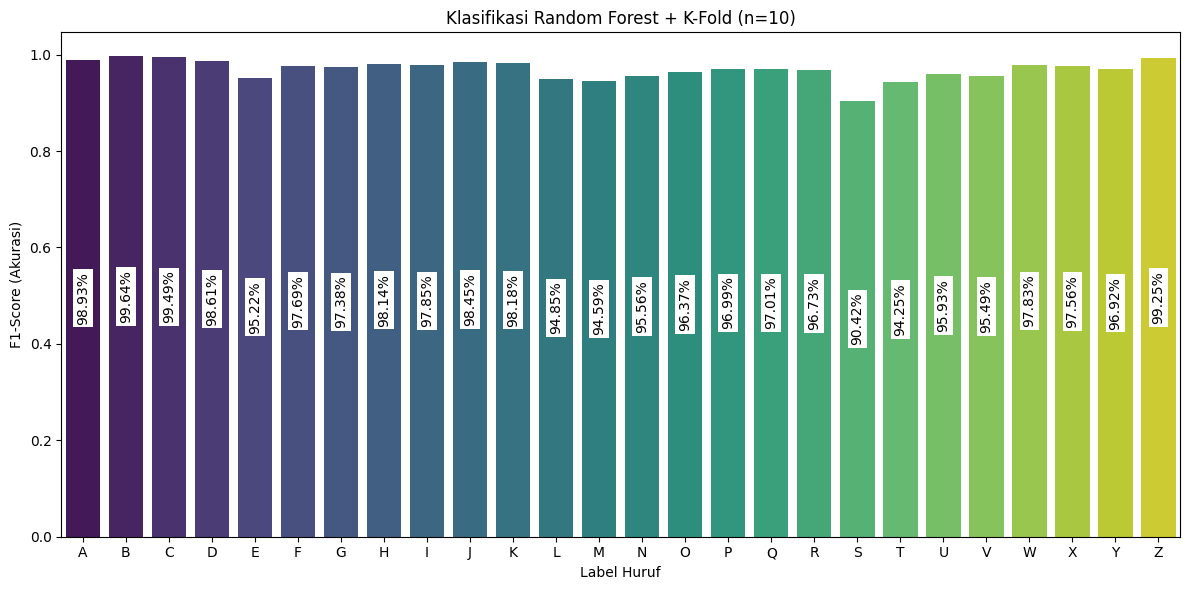

Final Test Accuracy: 0.9689754689754689
Classification Report (Test Data):
               precision    recall  f1-score   support

           A       0.98      1.00      0.99       180
           B       0.99      0.99      0.99       180
           C       0.97      0.98      0.98       170
           D       0.98      0.98      0.98       169
           E       0.94      0.96      0.95       179
           F       0.97      0.98      0.97       178
           G       0.97      0.97      0.97       146
           H       0.97      0.93      0.95       127
           I       0.98      0.99      0.99       179
           J       0.99      0.96      0.97       180
           K       0.96      0.99      0.97       177
           L       0.96      0.97      0.96       180
           M       0.96      0.91      0.94       174
           N       0.93      0.96      0.94       124
           O       0.95      0.98      0.97       146
           P       0.99      0.99      0.99       150
     

In [38]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Muat data
data_dict = pickle.load(open('../train_data.pickle', 'rb'))

# Filter hanya data dengan panjang fitur 42
valid_data = [sample for sample in data_dict['data'] if len(sample) == 42]
data = np.array(valid_data)
labels = np.array(data_dict['labels'][:len(valid_data)])

# Label dictionary
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}

# Split train-test
x_train_full, x_test, y_train_full, y_test = train_test_split(
    data, labels, test_size=0.30, stratify=labels, random_state=42
)

# Inisialisasi K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
all_y_true = []
all_y_pred = []
final_model = None

# Cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(x_train_full, y_train_full), 1):
    x_train, x_val = x_train_full[train_index], x_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    model = RandomForestClassifier(random_state=42)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

    print(f"Fold {fold} Accuracy: {acc:.4f}")

    final_model = model  # simpan model dari fold terakhir

# Rata-rata akurasi K-Fold
mean_kfold_acc = np.mean(accuracies)
print("\nMean K-Fold Accuracy:", mean_kfold_acc)

# Classification report untuk hasil K-Fold
class_names = [labels_dict[i] for i in sorted(labels_dict.keys())]
report_dict = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
report_kfold_text = classification_report(all_y_true, all_y_pred, target_names=class_names)
print("Classification Report (K-Fold):\n", report_kfold_text)

# Visualisasi F1-Score per kelas
f1_scores = [report_dict[label]['f1-score'] for label in class_names]
df_report = pd.DataFrame({'Label': class_names, 'F1-Score': f1_scores})

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis')
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score (Akurasi)')
plt.title('Klasifikasi Random Forest + K-Fold (n=10)')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height / 2.,
            '{:1.2f}%'.format(height * 100),
            ha='center', va='center', rotation='vertical',
            bbox=dict(facecolor='white', edgecolor='none', pad=2))

plt.tight_layout()
plt.show()

# Evaluasi pada test set
y_test_pred = final_model.predict(x_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("Final Test Accuracy:", test_acc)

# Classification report untuk test set
report_test = classification_report(y_test, y_test_pred, target_names=class_names)
print("Classification Report (Test Data):\n", report_test)

# Simpan model
model_folder = '../model-tuning/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

i = 1
model_filename = os.path.join(model_folder, 'rf_model_kfold.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_kfold_{i}.p')
    i += 1

with open(model_filename, 'wb') as f:
    pickle.dump({'model': final_model}, f)


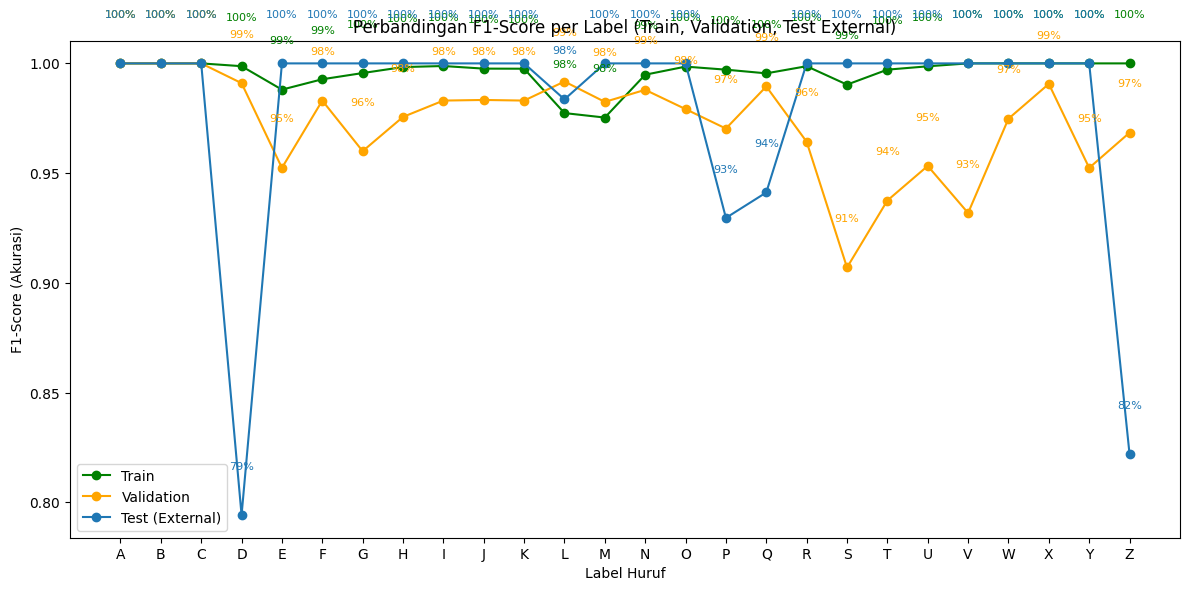

Train Accuracy: 99.57%
Validation Accuracy: 97.40%
Test Accuracy: 96.79%
External Accuracy: 97.91%


In [39]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import os
import seaborn as sns
import pandas as pd

# === LOAD & VALIDASI TRAIN DATA ===
data_dict = pickle.load(open('../train_data.pickle', 'rb'))
valid_data = [sample for sample in data_dict['data'] if len(sample) == 42]
data = np.array(valid_data)
labels = np.array(data_dict['labels'][:len(valid_data)])

# Buat label mapping
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}
class_names = list(sorted(labels_dict.values()))

# === SPLIT 70:10:20 ===
x_temp, x_test, y_temp, y_test = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42)  # 0.125 * 0.8 ≈ 0.10 total

# === TRAIN MODEL ===
model = RandomForestClassifier()
model.fit(x_train, y_train)

# === PREDIKSI DAN EVALUASI ===
def get_f1_scores(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    return [report[c]['f1-score'] for c in class_names], report

f1_train, report_train = get_f1_scores(y_train, model.predict(x_train))
f1_val, report_val = get_f1_scores(y_val, model.predict(x_val))
f1_test, report_test = get_f1_scores(y_test, model.predict(x_test))

# === LOAD TEST EKSTERNAL ===
test_data_dict = pickle.load(open('../test_data.pickle', 'rb'))
valid_test_data = [sample for sample in test_data_dict['data'] if len(sample) == 42]
if not valid_test_data:
    raise ValueError("No valid test data found.")
x_ext = np.array(valid_test_data)
y_ext = np.array(test_data_dict['labels'][:len(valid_test_data)])
f1_ext, report_ext = get_f1_scores(y_ext, model.predict(x_ext))

# === LINE PLOT F1-SCORE COMPARISON ===
plt.figure(figsize=(12, 6))
plt.plot(class_names, f1_train, marker='o', linestyle='-', color='green', label='Train')
plt.plot(class_names, f1_val, marker='o', linestyle='-', color='orange', label='Validation')
plt.plot(class_names, f1_ext, marker='o', linestyle='-', color='C0', label='Test (External)')

# Tambahkan nilai di atas titik
for x, y1, y2, y3 in zip(class_names, f1_train, f1_val, f1_ext):
    plt.text(x, y1 + 0.02, f'{y1*100:.0f}%', ha='center', va='bottom', color='green', fontsize=8)
    plt.text(x, y2 + 0.02, f'{y2*100:.0f}%', ha='center', va='bottom', color='orange', fontsize=8)
    plt.text(x, y3 + 0.02, f'{y3*100:.0f}%', ha='center', va='bottom', color='C0', fontsize=8)

plt.xlabel('Label Huruf')
plt.ylabel('F1-Score (Akurasi)')
plt.title('Perbandingan F1-Score per Label (Train, Validation, Test External)')
plt.legend()
plt.tight_layout()
plt.show()

# Cetak summary report (optional)
print("Train Accuracy: {:.2f}%".format(accuracy_score(y_train, model.predict(x_train)) * 100))
print("Validation Accuracy: {:.2f}%".format(accuracy_score(y_val, model.predict(x_val)) * 100))
print("Test Accuracy: {:.2f}%".format(accuracy_score(y_test, model.predict(x_test)) * 100))
print("External Accuracy: {:.2f}%".format(accuracy_score(y_ext, model.predict(x_ext)) * 100))
